In [1]:
!python --version

Python 3.11.5


In [2]:
import torch

torch.__version__

'2.1.0+cu121'

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup directory paths to train and test images
image_dir = "data/train"

# Create Datasets and DataLoaders

In [6]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

NUM_WORKERS = os.cpu_count()


def create_dataloaders(
    image_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    # Use ImageFolder to create dataset(s)
    dataset = datasets.ImageFolder(image_dir, transform=transform)
    
    # Get class names
    class_names = dataset.classes

    train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [7]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    image_dir=image_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa8d1435390>,
 ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009'])

torch.Size([3, 224, 224]) tensor(5)


(-0.5, 223.5, 223.5, -0.5)

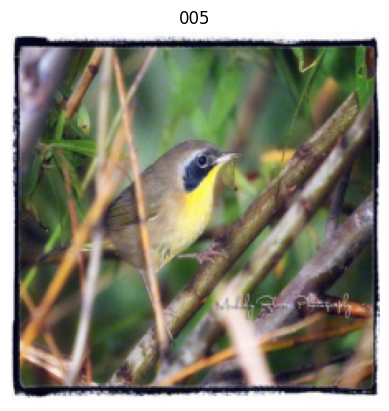

In [9]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

# Step 1 

#### Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C)       #Current shape: (1, 768, 196)

In [11]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    # 2. Initialize the class with appropriate variables
    def __init__(
        self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768
    ):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim=2,  # only flatten the feature map dimensions into a single vector
            end_dim=3,
        )

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert (
            image_resolution % patch_size == 0
        ), f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(
            0, 2, 1
        )  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

# PatchEmbedding layer ready

In [13]:
# Let's test it on single image
patch_size = 16


# Set seeds
def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(
    image.unsqueeze(0)
)  # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [14]:
# View the patch embedding and patch embedding shape


print(patch_embedded_image)
print(
    f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]"
)

tensor([[[ 0.0777,  0.3118, -0.1409,  ...,  0.5179, -0.6674,  0.2896],
         [-0.1523,  0.2245,  0.1108,  ...,  0.5706, -0.3264,  0.1626],
         [-0.2846, -0.0008,  0.3742,  ...,  0.3371, -0.5578, -0.1027],
         ...,
         [-0.4240,  0.2153, -0.4730,  ...,  0.5894, -0.2848,  0.0805],
         [-0.5405,  0.2182, -0.5006,  ...,  0.4678, -0.4662,  0.0632],
         [-0.3480,  0.4332, -0.3951,  ...,  0.3474, -0.4568,  0.3507]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [15]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0777,  0.3118, -0.1409,  ...,  0.5179, -0.6674,  0.2896],
         [-0.1523,  0.2245,  0.1108,  ...,  0.5706, -0.3264,  0.1626],
         ...,
         [-0.4240,  0.2153, -0.4730,  ...,  0.5894, -0.2848,  0.0805],
         [-0.5405,  0.2182, -0.5006,  ...,  0.4678, -0.4662,  0.0632],
         [-0.3480,  0.4332, -0.3951,  ...,  0.3474, -0.4568,  0.3507]]],
       grad_fn=<CatBackward0>)


In [16]:
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0777, 1.3118, 0.8591,  ..., 1.5179, 0.3326, 1.2896],
         [0.8477, 1.2245, 1.1108,  ..., 1.5706, 0.6736, 1.1626],
         ...,
         [0.5760, 1.2153, 0.5270,  ..., 1.5894, 0.7152, 1.0805],
         [0.4595, 1.2182, 0.4994,  ..., 1.4678, 0.5338, 1.0632],
         [0.6520, 1.4332, 0.6049,  ..., 1.3474, 0.5432, 1.3507]]],
       grad_fn=<AddBackward0>)


Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

# Lets create layers used in Transformer's encoder:


#### Norm (LN or LayerNorm) - torch.nn.LayerNorm().

Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).


#### We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

Multi-Head Self Attention (MSA) - <b>torch.nn.MultiheadAttention()</b>

    embed_dim - the embedding dimension D .

    num_heads - how many attention heads to use (this is where the term "multihead" comes from)

    dropout - whether or not to apply dropout to the attention layer 

    batch_first - does our batch dimension come first? (yes it does)

In [21]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,
    ):  # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )  # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,  # query embeddings
            key=x,  # key embeddings
            value=x,  # value embeddings
            need_weights=False,
        )  # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [22]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden Size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        dropout: float = 0.1,
    ):  # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,  # needs to take same in_features as out_features of layer above
                out_features=embedding_dim,
            ),  # take back to embedding_dim
            nn.Dropout(
                p=dropout
            ),  # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Creating a Transformer Encoder by combining our custom made layers

In below cell we are creating transformer encoder ourself

In [19]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        mlp_dropout: float = 0.1,  # Amount of dropout for dense layers from Table 3 for ViT-Base
        attn_dropout: float = 0,
    ):  # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout
        )

        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout
        )

    # 5. Create a forward() method
    def forward(self, x):
        # 6. Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

#### Transformer Encoder block created!

In [25]:
!pip install -q torchinfo

In [26]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Let's build a vision transformer

In [28]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        img_size: int = 224,  # Training resolution from Table 3 in ViT paper
        in_channels: int = 3,  # Number of channels in input image
        patch_size: int = 16,  # Patch size
        num_transformer_layers: int = 12,  # Layers from Table 1 for ViT-Base
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,  # Dropout for attention projection
        mlp_dropout: float = 0.1,  # Dropout for dense/MLP layers
        embedding_dropout: float = 0.1,  # Dropout for patch and position embeddings
        num_classes: int = 1000,
    ):  # Default for ImageNet but can customize this
        super().__init__()  # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert (
            img_size % patch_size == 0
        ), f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim), requires_grad=True
        )

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True
        )

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim
        )

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_transformer_layers)
            ]
        )

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    # 11. Create a forward() method
    def forward(self, x):
        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(
            batch_size, -1, -1
        )  # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

        return x

# Train Model

In [29]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

In [31]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3,  # Base LR from Table 3 for ViT-* ImageNet-1k
    betas=(
        0.9,
        0.999,
    ),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
    weight_decay=0.3,
)  # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=100,
    device=device,
)

  1%|          | 1/100 [00:03<05:09,  3.13s/it]

Epoch: 1 | train_loss: 2.6432 | train_acc: 0.0807 | test_loss: 2.3947 | test_acc: 0.1082


  2%|▏         | 2/100 [00:05<04:49,  2.96s/it]

Epoch: 2 | train_loss: 2.3713 | train_acc: 0.0833 | test_loss: 2.3982 | test_acc: 0.0661


  3%|▎         | 3/100 [00:08<04:41,  2.90s/it]

Epoch: 3 | train_loss: 2.3538 | train_acc: 0.1263 | test_loss: 2.4378 | test_acc: 0.0469


  4%|▍         | 4/100 [00:11<04:35,  2.87s/it]

Epoch: 4 | train_loss: 2.4151 | train_acc: 0.1003 | test_loss: 2.3463 | test_acc: 0.1238


  5%|▌         | 5/100 [00:14<04:31,  2.86s/it]

Epoch: 5 | train_loss: 2.4181 | train_acc: 0.1016 | test_loss: 2.4372 | test_acc: 0.0661


  6%|▌         | 6/100 [00:17<04:28,  2.85s/it]

Epoch: 6 | train_loss: 2.4112 | train_acc: 0.0742 | test_loss: 2.3358 | test_acc: 0.0469


  7%|▋         | 7/100 [00:20<04:25,  2.86s/it]

Epoch: 7 | train_loss: 2.3389 | train_acc: 0.1094 | test_loss: 2.3936 | test_acc: 0.1082


  8%|▊         | 8/100 [00:23<04:22,  2.86s/it]

Epoch: 8 | train_loss: 2.3286 | train_acc: 0.1185 | test_loss: 2.3103 | test_acc: 0.0661


  9%|▉         | 9/100 [00:25<04:19,  2.85s/it]

Epoch: 9 | train_loss: 2.3593 | train_acc: 0.0964 | test_loss: 2.3657 | test_acc: 0.0469


 10%|█         | 10/100 [00:28<04:17,  2.86s/it]

Epoch: 10 | train_loss: 2.3820 | train_acc: 0.0977 | test_loss: 2.3187 | test_acc: 0.1238


 11%|█         | 11/100 [00:31<04:14,  2.86s/it]

Epoch: 11 | train_loss: 2.3516 | train_acc: 0.0534 | test_loss: 2.3453 | test_acc: 0.0661


 12%|█▏        | 12/100 [00:34<04:11,  2.86s/it]

Epoch: 12 | train_loss: 2.3535 | train_acc: 0.0938 | test_loss: 2.3406 | test_acc: 0.1082


 13%|█▎        | 13/100 [00:37<04:08,  2.86s/it]

Epoch: 13 | train_loss: 2.3371 | train_acc: 0.1029 | test_loss: 2.3138 | test_acc: 0.1082


 14%|█▍        | 14/100 [00:40<04:06,  2.86s/it]

Epoch: 14 | train_loss: 2.3559 | train_acc: 0.0781 | test_loss: 2.3479 | test_acc: 0.0661


 15%|█▌        | 15/100 [00:43<04:03,  2.87s/it]

Epoch: 15 | train_loss: 2.3413 | train_acc: 0.1081 | test_loss: 2.3593 | test_acc: 0.0469


 16%|█▌        | 16/100 [00:45<04:01,  2.88s/it]

Epoch: 16 | train_loss: 2.3333 | train_acc: 0.0820 | test_loss: 2.2981 | test_acc: 0.1082


 17%|█▋        | 17/100 [00:48<03:58,  2.87s/it]

Epoch: 17 | train_loss: 2.3290 | train_acc: 0.0924 | test_loss: 2.3853 | test_acc: 0.0974


 18%|█▊        | 18/100 [00:51<04:00,  2.93s/it]

Epoch: 18 | train_loss: 2.3321 | train_acc: 0.0820 | test_loss: 2.3655 | test_acc: 0.0661


 19%|█▉        | 19/100 [00:54<03:59,  2.96s/it]

Epoch: 19 | train_loss: 2.3288 | train_acc: 0.0625 | test_loss: 2.3144 | test_acc: 0.0661


 20%|██        | 20/100 [00:57<03:56,  2.96s/it]

Epoch: 20 | train_loss: 2.3104 | train_acc: 0.0872 | test_loss: 2.3550 | test_acc: 0.0469


 21%|██        | 21/100 [01:00<03:53,  2.95s/it]

Epoch: 21 | train_loss: 2.3296 | train_acc: 0.1120 | test_loss: 2.3372 | test_acc: 0.0469


 22%|██▏       | 22/100 [01:03<03:51,  2.97s/it]

Epoch: 22 | train_loss: 2.3191 | train_acc: 0.1042 | test_loss: 2.3263 | test_acc: 0.0661


 23%|██▎       | 23/100 [01:06<03:49,  2.98s/it]

Epoch: 23 | train_loss: 2.3106 | train_acc: 0.0846 | test_loss: 2.3535 | test_acc: 0.0469


 24%|██▍       | 24/100 [01:09<03:46,  2.98s/it]

Epoch: 24 | train_loss: 2.3242 | train_acc: 0.1055 | test_loss: 2.3295 | test_acc: 0.0974


 25%|██▌       | 25/100 [01:12<03:43,  2.98s/it]

Epoch: 25 | train_loss: 2.3105 | train_acc: 0.0977 | test_loss: 2.3282 | test_acc: 0.1082


 26%|██▌       | 26/100 [01:15<03:40,  2.98s/it]

Epoch: 26 | train_loss: 2.3120 | train_acc: 0.1367 | test_loss: 2.3459 | test_acc: 0.0661


 27%|██▋       | 27/100 [01:18<03:37,  2.98s/it]

Epoch: 27 | train_loss: 2.3155 | train_acc: 0.1081 | test_loss: 2.3495 | test_acc: 0.0469


 28%|██▊       | 28/100 [01:21<03:35,  2.99s/it]

Epoch: 28 | train_loss: 2.3146 | train_acc: 0.0846 | test_loss: 2.3154 | test_acc: 0.0661


 29%|██▉       | 29/100 [01:24<03:32,  2.99s/it]

Epoch: 29 | train_loss: 2.3140 | train_acc: 0.1003 | test_loss: 2.3248 | test_acc: 0.0469


 30%|███       | 30/100 [01:27<03:29,  2.99s/it]

Epoch: 30 | train_loss: 2.3040 | train_acc: 0.1146 | test_loss: 2.3155 | test_acc: 0.0469


 31%|███       | 31/100 [01:30<03:25,  2.98s/it]

Epoch: 31 | train_loss: 2.3109 | train_acc: 0.1159 | test_loss: 2.3290 | test_acc: 0.0661


 32%|███▏      | 32/100 [01:33<03:22,  2.98s/it]

Epoch: 32 | train_loss: 2.3030 | train_acc: 0.1146 | test_loss: 2.3280 | test_acc: 0.0661


 33%|███▎      | 33/100 [01:36<03:20,  2.99s/it]

Epoch: 33 | train_loss: 2.3049 | train_acc: 0.0742 | test_loss: 2.3359 | test_acc: 0.1082


 34%|███▍      | 34/100 [01:39<03:20,  3.04s/it]

Epoch: 34 | train_loss: 2.3079 | train_acc: 0.0820 | test_loss: 2.3345 | test_acc: 0.0661


 35%|███▌      | 35/100 [01:42<03:18,  3.06s/it]

Epoch: 35 | train_loss: 2.3034 | train_acc: 0.1016 | test_loss: 2.3197 | test_acc: 0.0469


 36%|███▌      | 36/100 [01:46<03:16,  3.07s/it]

Epoch: 36 | train_loss: 2.3037 | train_acc: 0.1120 | test_loss: 2.3255 | test_acc: 0.0469


 37%|███▋      | 37/100 [01:49<03:14,  3.08s/it]

Epoch: 37 | train_loss: 2.3033 | train_acc: 0.1120 | test_loss: 2.3235 | test_acc: 0.0469


 38%|███▊      | 38/100 [01:52<03:11,  3.08s/it]

Epoch: 38 | train_loss: 2.3015 | train_acc: 0.1120 | test_loss: 2.3242 | test_acc: 0.0469


 39%|███▉      | 39/100 [01:55<03:08,  3.08s/it]

Epoch: 39 | train_loss: 2.3030 | train_acc: 0.1120 | test_loss: 2.3241 | test_acc: 0.0661


 40%|████      | 40/100 [01:58<03:04,  3.08s/it]

Epoch: 40 | train_loss: 2.3032 | train_acc: 0.1016 | test_loss: 2.3209 | test_acc: 0.0661


 41%|████      | 41/100 [02:01<03:01,  3.08s/it]

Epoch: 41 | train_loss: 2.3013 | train_acc: 0.1107 | test_loss: 2.3186 | test_acc: 0.0661


 42%|████▏     | 42/100 [02:04<02:59,  3.09s/it]

Epoch: 42 | train_loss: 2.3029 | train_acc: 0.1055 | test_loss: 2.3227 | test_acc: 0.0469


 43%|████▎     | 43/100 [02:07<02:56,  3.10s/it]

Epoch: 43 | train_loss: 2.3026 | train_acc: 0.1159 | test_loss: 2.3241 | test_acc: 0.0661


 44%|████▍     | 44/100 [02:10<02:53,  3.10s/it]

Epoch: 44 | train_loss: 2.2993 | train_acc: 0.0990 | test_loss: 2.3219 | test_acc: 0.0661


 45%|████▌     | 45/100 [02:13<02:50,  3.09s/it]

Epoch: 45 | train_loss: 2.2997 | train_acc: 0.0755 | test_loss: 2.3219 | test_acc: 0.0661


 46%|████▌     | 46/100 [02:16<02:47,  3.10s/it]

Epoch: 46 | train_loss: 2.2996 | train_acc: 0.1211 | test_loss: 2.3225 | test_acc: 0.0661


 47%|████▋     | 47/100 [02:20<02:44,  3.10s/it]

Epoch: 47 | train_loss: 2.3029 | train_acc: 0.1016 | test_loss: 2.3229 | test_acc: 0.0661


 48%|████▊     | 48/100 [02:23<02:41,  3.11s/it]

Epoch: 48 | train_loss: 2.3008 | train_acc: 0.0781 | test_loss: 2.3204 | test_acc: 0.0661


 49%|████▉     | 49/100 [02:26<02:38,  3.10s/it]

Epoch: 49 | train_loss: 2.3004 | train_acc: 0.1068 | test_loss: 2.3183 | test_acc: 0.0661


 50%|█████     | 50/100 [02:29<02:35,  3.10s/it]

Epoch: 50 | train_loss: 2.2998 | train_acc: 0.1042 | test_loss: 2.3159 | test_acc: 0.0661


 51%|█████     | 51/100 [02:32<02:32,  3.10s/it]

Epoch: 51 | train_loss: 2.2987 | train_acc: 0.1133 | test_loss: 2.3163 | test_acc: 0.0469


 52%|█████▏    | 52/100 [02:35<02:28,  3.10s/it]

Epoch: 52 | train_loss: 2.3002 | train_acc: 0.0755 | test_loss: 2.3153 | test_acc: 0.0469


 53%|█████▎    | 53/100 [02:38<02:25,  3.10s/it]

Epoch: 53 | train_loss: 2.3008 | train_acc: 0.1120 | test_loss: 2.3145 | test_acc: 0.0469


 54%|█████▍    | 54/100 [02:41<02:21,  3.07s/it]

Epoch: 54 | train_loss: 2.2988 | train_acc: 0.1250 | test_loss: 2.3118 | test_acc: 0.0469


 55%|█████▌    | 55/100 [02:44<02:18,  3.09s/it]

Epoch: 55 | train_loss: 2.2995 | train_acc: 0.1185 | test_loss: 2.3123 | test_acc: 0.0469


 56%|█████▌    | 56/100 [02:47<02:16,  3.09s/it]

Epoch: 56 | train_loss: 2.3011 | train_acc: 0.1185 | test_loss: 2.3126 | test_acc: 0.0469


 57%|█████▋    | 57/100 [02:51<02:12,  3.09s/it]

Epoch: 57 | train_loss: 2.3003 | train_acc: 0.1120 | test_loss: 2.3119 | test_acc: 0.0469


 58%|█████▊    | 58/100 [02:54<02:09,  3.08s/it]

Epoch: 58 | train_loss: 2.3010 | train_acc: 0.1055 | test_loss: 2.3114 | test_acc: 0.0469


 59%|█████▉    | 59/100 [02:57<02:06,  3.08s/it]

Epoch: 59 | train_loss: 2.3011 | train_acc: 0.1055 | test_loss: 2.3107 | test_acc: 0.0469


 60%|██████    | 60/100 [03:00<02:03,  3.08s/it]

Epoch: 60 | train_loss: 2.3003 | train_acc: 0.1185 | test_loss: 2.3097 | test_acc: 0.0469


 61%|██████    | 61/100 [03:03<02:00,  3.08s/it]

Epoch: 61 | train_loss: 2.3005 | train_acc: 0.1185 | test_loss: 2.3094 | test_acc: 0.0469


 62%|██████▏   | 62/100 [03:06<01:56,  3.08s/it]

Epoch: 62 | train_loss: 2.3011 | train_acc: 0.1120 | test_loss: 2.3089 | test_acc: 0.0469


 63%|██████▎   | 63/100 [03:09<01:54,  3.08s/it]

Epoch: 63 | train_loss: 2.3013 | train_acc: 0.1120 | test_loss: 2.3088 | test_acc: 0.0469


 64%|██████▍   | 64/100 [03:12<01:50,  3.08s/it]

Epoch: 64 | train_loss: 2.3011 | train_acc: 0.1185 | test_loss: 2.3085 | test_acc: 0.0469


 65%|██████▌   | 65/100 [03:15<01:47,  3.08s/it]

Epoch: 65 | train_loss: 2.3012 | train_acc: 0.1185 | test_loss: 2.3088 | test_acc: 0.0469


 66%|██████▌   | 66/100 [03:18<01:44,  3.08s/it]

Epoch: 66 | train_loss: 2.3010 | train_acc: 0.1055 | test_loss: 2.3086 | test_acc: 0.0469


 67%|██████▋   | 67/100 [03:21<01:41,  3.07s/it]

Epoch: 67 | train_loss: 2.3004 | train_acc: 0.1185 | test_loss: 2.3083 | test_acc: 0.0469


 68%|██████▊   | 68/100 [03:24<01:38,  3.07s/it]

Epoch: 68 | train_loss: 2.3013 | train_acc: 0.1120 | test_loss: 2.3084 | test_acc: 0.0469


 69%|██████▉   | 69/100 [03:27<01:35,  3.07s/it]

Epoch: 69 | train_loss: 2.3011 | train_acc: 0.1055 | test_loss: 2.3081 | test_acc: 0.0469


 70%|███████   | 70/100 [03:30<01:32,  3.07s/it]

Epoch: 70 | train_loss: 2.3006 | train_acc: 0.1185 | test_loss: 2.3078 | test_acc: 0.0469


 71%|███████   | 71/100 [03:34<01:29,  3.08s/it]

Epoch: 71 | train_loss: 2.3005 | train_acc: 0.1315 | test_loss: 2.3074 | test_acc: 0.0469


 72%|███████▏  | 72/100 [03:37<01:26,  3.07s/it]

Epoch: 72 | train_loss: 2.3013 | train_acc: 0.1120 | test_loss: 2.3076 | test_acc: 0.0469


 73%|███████▎  | 73/100 [03:40<01:23,  3.07s/it]

Epoch: 73 | train_loss: 2.3004 | train_acc: 0.1250 | test_loss: 2.3077 | test_acc: 0.0469


 74%|███████▍  | 74/100 [03:43<01:19,  3.08s/it]

Epoch: 74 | train_loss: 2.3007 | train_acc: 0.1120 | test_loss: 2.3080 | test_acc: 0.0469


 75%|███████▌  | 75/100 [03:46<01:16,  3.08s/it]

Epoch: 75 | train_loss: 2.3004 | train_acc: 0.1055 | test_loss: 2.3078 | test_acc: 0.0469


 76%|███████▌  | 76/100 [03:49<01:13,  3.06s/it]

Epoch: 76 | train_loss: 2.3006 | train_acc: 0.1055 | test_loss: 2.3079 | test_acc: 0.0469


 77%|███████▋  | 77/100 [03:52<01:10,  3.06s/it]

Epoch: 77 | train_loss: 2.3004 | train_acc: 0.1055 | test_loss: 2.3081 | test_acc: 0.0469


 78%|███████▊  | 78/100 [03:55<01:07,  3.07s/it]

Epoch: 78 | train_loss: 2.3011 | train_acc: 0.1185 | test_loss: 2.3083 | test_acc: 0.0469


 79%|███████▉  | 79/100 [03:58<01:04,  3.06s/it]

Epoch: 79 | train_loss: 2.3015 | train_acc: 0.1055 | test_loss: 2.3084 | test_acc: 0.0469


 80%|████████  | 80/100 [04:01<01:01,  3.07s/it]

Epoch: 80 | train_loss: 2.3013 | train_acc: 0.1055 | test_loss: 2.3085 | test_acc: 0.0469


 81%|████████  | 81/100 [04:04<00:58,  3.07s/it]

Epoch: 81 | train_loss: 2.3016 | train_acc: 0.1120 | test_loss: 2.3079 | test_acc: 0.0469


 82%|████████▏ | 82/100 [04:07<00:55,  3.07s/it]

Epoch: 82 | train_loss: 2.3012 | train_acc: 0.1120 | test_loss: 2.3076 | test_acc: 0.0469


 83%|████████▎ | 83/100 [04:10<00:52,  3.07s/it]

Epoch: 83 | train_loss: 2.3008 | train_acc: 0.1055 | test_loss: 2.3075 | test_acc: 0.0469


 84%|████████▍ | 84/100 [04:13<00:49,  3.07s/it]

Epoch: 84 | train_loss: 2.3014 | train_acc: 0.1055 | test_loss: 2.3073 | test_acc: 0.0469


 85%|████████▌ | 85/100 [04:17<00:46,  3.07s/it]

Epoch: 85 | train_loss: 2.3007 | train_acc: 0.1120 | test_loss: 2.3070 | test_acc: 0.0469


 86%|████████▌ | 86/100 [04:20<00:43,  3.07s/it]

Epoch: 86 | train_loss: 2.3012 | train_acc: 0.1120 | test_loss: 2.3068 | test_acc: 0.0469


 87%|████████▋ | 87/100 [04:23<00:39,  3.08s/it]

Epoch: 87 | train_loss: 2.3013 | train_acc: 0.1055 | test_loss: 2.3070 | test_acc: 0.0469


 88%|████████▊ | 88/100 [04:26<00:36,  3.08s/it]

Epoch: 88 | train_loss: 2.3005 | train_acc: 0.1120 | test_loss: 2.3070 | test_acc: 0.0469


 89%|████████▉ | 89/100 [04:29<00:33,  3.08s/it]

Epoch: 89 | train_loss: 2.3006 | train_acc: 0.1120 | test_loss: 2.3073 | test_acc: 0.0469


 90%|█████████ | 90/100 [04:32<00:30,  3.08s/it]

Epoch: 90 | train_loss: 2.3000 | train_acc: 0.0885 | test_loss: 2.3073 | test_acc: 0.0974


 91%|█████████ | 91/100 [04:35<00:27,  3.08s/it]

Epoch: 91 | train_loss: 2.3004 | train_acc: 0.0938 | test_loss: 2.3079 | test_acc: 0.0469


 92%|█████████▏| 92/100 [04:38<00:24,  3.07s/it]

Epoch: 92 | train_loss: 2.3008 | train_acc: 0.1185 | test_loss: 2.3084 | test_acc: 0.0469


 93%|█████████▎| 93/100 [04:41<00:21,  3.08s/it]

Epoch: 93 | train_loss: 2.3006 | train_acc: 0.1185 | test_loss: 2.3088 | test_acc: 0.0469


 94%|█████████▍| 94/100 [04:44<00:18,  3.07s/it]

Epoch: 94 | train_loss: 2.2997 | train_acc: 0.1315 | test_loss: 2.3085 | test_acc: 0.0469


 95%|█████████▌| 95/100 [04:47<00:15,  3.07s/it]

Epoch: 95 | train_loss: 2.3020 | train_acc: 0.1120 | test_loss: 2.3089 | test_acc: 0.0469


 96%|█████████▌| 96/100 [04:50<00:12,  3.07s/it]

Epoch: 96 | train_loss: 2.3021 | train_acc: 0.1120 | test_loss: 2.3090 | test_acc: 0.0469


 97%|█████████▋| 97/100 [04:53<00:09,  3.07s/it]

Epoch: 97 | train_loss: 2.3010 | train_acc: 0.1185 | test_loss: 2.3085 | test_acc: 0.0469


 98%|█████████▊| 98/100 [04:56<00:06,  3.06s/it]

Epoch: 98 | train_loss: 2.3008 | train_acc: 0.1120 | test_loss: 2.3081 | test_acc: 0.0469


 99%|█████████▉| 99/100 [04:59<00:03,  3.06s/it]

Epoch: 99 | train_loss: 2.3012 | train_acc: 0.1055 | test_loss: 2.3079 | test_acc: 0.0469


100%|██████████| 100/100 [05:03<00:00,  3.03s/it]

Epoch: 100 | train_loss: 2.3009 | train_acc: 0.1120 | test_loss: 2.3078 | test_acc: 0.0469


Our ViT model has come to life!

Results on our custom dataset don't look too good.

Lets plot the accuracy and loss curves

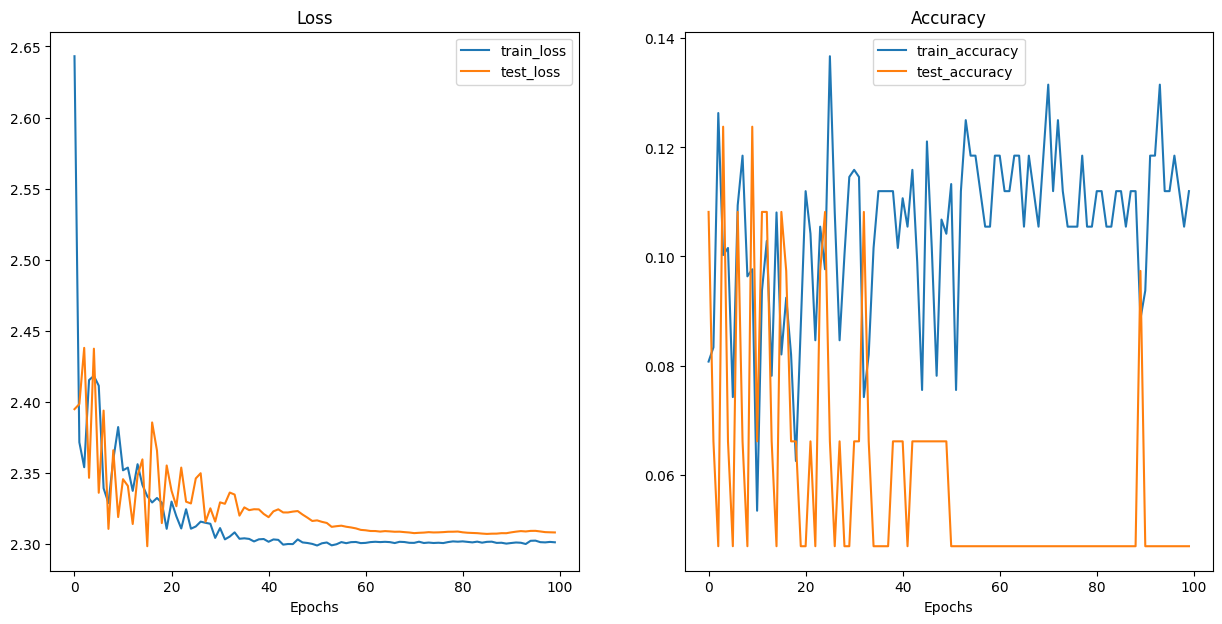

In [32]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Predictions

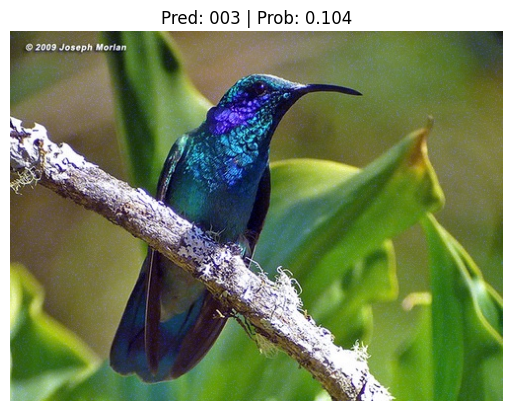

In [35]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(model=vit, image_path=custom_image_path, class_names=class_names)

# Next part - Create Image classifier using pretrained model